<a href="https://colab.research.google.com/github/adityakarwani/Sentiment-Analysis-using-RNN/blob/main/sentiment_analysis_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore", category=FutureWarning)
from tensorflow import keras
from keras.layers import Dense ,Embedding,SpatialDropout1D,LSTM,Dropout
from tensorflow.keras.models import Sequential

In [ ]:
data=pd.read_csv("/content/Tweets.csv")

In [ ]:
data

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [ ]:
data.sample()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
3535,568283819477839872,negative,1.0,Late Flight,0.6816,United,NaN,Hanagavadi,NaN,0,@united ... horrible wait time on 4348 to get ...,NaN,2015-02-18 21:39:55 -0800,NaN,NaN


In [ ]:
df = data[["text","airline_sentiment"]]
df['text'] = df['text'].map(lambda x: x.lstrip('@VirginAmerica@UnitedAir@Southwestairline@DeltaAir@USAirways@American').rstrip('@'))

<ipython-input-12-0ce3478a8118>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].map(lambda x: x.lstrip('@VirginAmerica@UnitedAir@Southwestairline@DeltaAir@USAirways@American').rstrip('@'))


In [ ]:
df.sample()

,text,airline_sentiment
561,When will email address/username sign-on be a...,negative


In [ ]:
df

,text,airline_sentiment
0,What @dhepburn said.,neutral
1,plus you've added commercials to the experien...,positive
2,I didn't today... Must mean I need to take an...,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative
4,and it's a really big bad thing about it,negative
...,...,...
14635,thank you we got on a different flight to Chi...,positive
14636,leaving over 20 minutes Late Flight. No warni...,negative
14637,Please bring American Airlines to #BlackBerry10,neutral
14638,"you have my money, you change my flight, and ...",negative


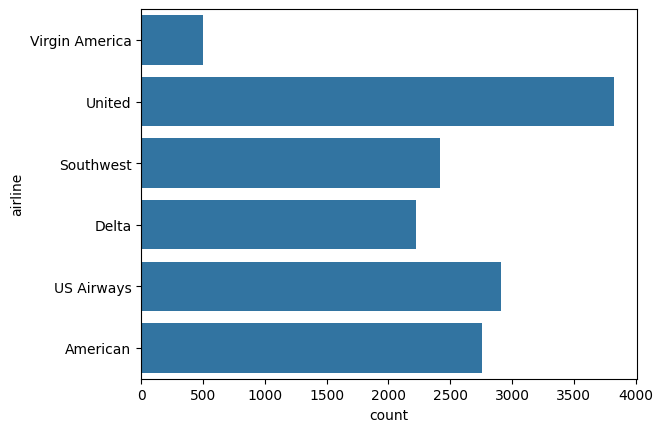

In [ ]:
sns.countplot(data.airline);

In [ ]:
df = df[df.airline_sentiment!="neutral"] # To remove neutral responses
df['text'] = df['text'].apply(lambda x: x.lower()) # To lower
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # To keep numbers and strings only


<ipython-input-16-2e7e31eb758f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda x: x.lower()) # To lower
<ipython-input-16-2e7e31eb758f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # To keep numbers and strings only


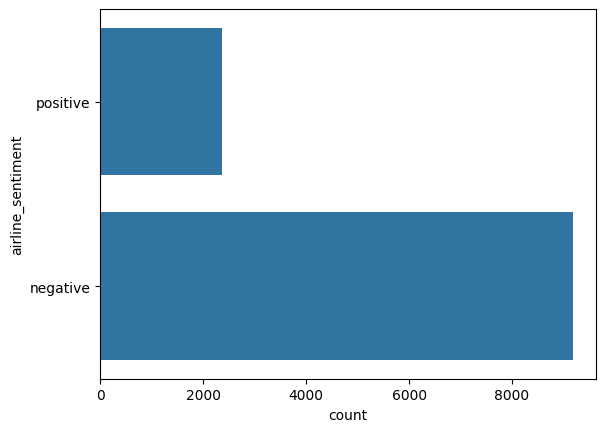

In [ ]:
sns.countplot(df.airline_sentiment);

In [ ]:
df = df.drop(df[df.airline_sentiment == "negative"].iloc[:5000].index)

In [ ]:
df.shape

(6541, 2)

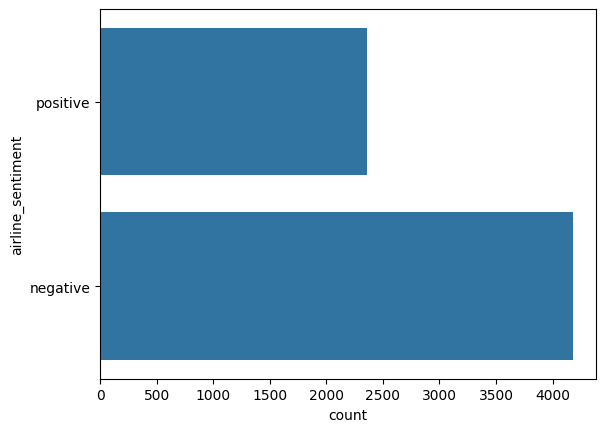

In [ ]:
sns.countplot(df.airline_sentiment);


In [ ]:
max_fatures = 4000
tokenizer = Tokenizer(num_words = max_fatures, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X)
Y = df['airline_sentiment']
L = Y.values
X
L

NameError: name 'Tokenizer' is not defined

In [ ]:
k = []
for i in range(6541):
    if L[i]=="negative":
                        k.append(0)
    elif L[i]=="positive":
                        k.append(1)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, k,
                                                    test_size=0.3,
                                                    shuffle = True,
                                                    stratify = k,
                                                    random_state = 1 )

In [ ]:
from tensorflow.keras.regularizers import l2
embed_dim = 128
lstm_out = 196
model = Sequential()
model.add(Embedding(max_fatures, embed_dim, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5))  # Increase dropout rates
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))  # Add L2 regularization
model.add(Dropout(0.5))  # Increase dropout rate
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
import numpy as np
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
Model = model.fit(X_train,
                         Y_train,
                         epochs=20,
                         batch_size=32,
                         validation_split = 0.2,
                         verbose = 2)

Epoch 1/20
115/115 - 23s - loss: 1.0207 - accuracy: 0.7441 - val_loss: 0.4968 - val_accuracy: 0.8308 - 23s/epoch - 198ms/step
Epoch 2/20
115/115 - 13s - loss: 0.3342 - accuracy: 0.8883 - val_loss: 0.2910 - val_accuracy: 0.8941 - 13s/epoch - 111ms/step
Epoch 3/20
115/115 - 12s - loss: 0.2010 - accuracy: 0.9342 - val_loss: 0.2397 - val_accuracy: 0.9181 - 12s/epoch - 106ms/step
Epoch 4/20
115/115 - 12s - loss: 0.1482 - accuracy: 0.9533 - val_loss: 0.2281 - val_accuracy: 0.9192 - 12s/epoch - 102ms/step
Epoch 5/20
115/115 - 12s - loss: 0.1142 - accuracy: 0.9672 - val_loss: 0.2515 - val_accuracy: 0.9203 - 12s/epoch - 102ms/step
Epoch 6/20
115/115 - 13s - loss: 0.1068 - accuracy: 0.9702 - val_loss: 0.2457 - val_accuracy: 0.8963 - 13s/epoch - 109ms/step
Epoch 7/20
115/115 - 12s - loss: 0.0815 - accuracy: 0.9798 - val_loss: 0.2710 - val_accuracy: 0.9247 - 12s/epoch - 103ms/step
Epoch 8/20
115/115 - 12s - loss: 0.0597 - accuracy: 0.9858 - val_loss: 0.2585 - val_accuracy: 0.9148 - 12s/epoch - 103

In [ ]:

score = model.evaluate(X_test, Y_test, verbose=False)
print("loss = ",score[0])
print("accuracy = ",score[1])

loss =  0.41612178087234497
accuracy =  0.9103413224220276


In [ ]:
sample = ['noob  service']
sample = tokenizer.texts_to_sequences(sample)
sample = pad_sequences(sample, maxlen=31, dtype='int32', value=0)
print(sample)
sentiment = model.predict(sample,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

NameError: name 'tokenizer' is not defined

62/62 [==============================] - 1s 10ms/step


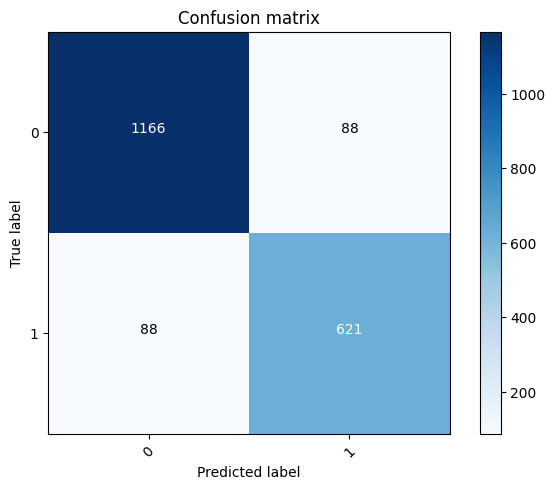

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis = 1)
confusion_mtx = confusion_matrix(Y_test, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(2))